# TD1 : Classification supervisée probabiliste (Nativel Emmanuel 36008527)

## Exercice 1.2 : implémentation de l'algorithme K-NN

### Représentation des données

Les données sont représentées dans un dataFrame.
Contrainte : la colonne des classes doit être nommée "Class".

In [1]:
import pandas as pd

# Liste des attributs
attributs = ["Age", "Emprunt", "Class"]

#Mes données sous forme de dictionnaire
data = {
    "Age" : [25, 35, 45, 20, 35, 52, 23, 40, 60, 48, 33], 
    "Emprunt" : [40000, 60000, 80000, 20000, 120000, 18000, 95000, 62000, 100000, 220000, 150000], 
    "Class" : ["N", "N", "N", "N", "N", "N", "Y", "Y", "Y", "Y", "Y"]
}

dimension = 11

#Les index : x1, x2... x11
index = ['x'+str(i) for i in range(1, dimension+1)]

#Création du dataFrame
df = pd.DataFrame(data, index = index)

print("Représentation des données de l'exercice : \n")
print(df)

Représentation des données de l'exercice : 

     Age  Emprunt Class
x1    25    40000     N
x2    35    60000     N
x3    45    80000     N
x4    20    20000     N
x5    35   120000     N
x6    52    18000     N
x7    23    95000     Y
x8    40    62000     Y
x9    60   100000     Y
x10   48   220000     Y
x11   33   150000     Y


### Normalisation grâce à l'algorithme min-max

In [2]:
# Normalisation du dataFrame et sauvegarde des valeurs min/max pour chaque attribut
# INPUT : 
    ## dataFrame --> Le dataFrame non normalisé
    ## listMin -->  Une série (pandas) vide qui va stocker les valeurs minimales de chaque attributs 
    ## listMax -->  Une série (pandas) vide qui va stocker les valeurs maximales de chaque attributs 
# OUTPUT : 
    ## Renvoi le dataFrame avec des données normalisées grâce à l'algorithme min-max
# EFFET DE BORD : 
    ## Remplissage des Séries listMin et listMax
def normaliseMinMaxData(dataFrame, listMin, listMax) :
    dataFrame_normalised = dataFrame.copy()
    for i in dataFrame : 
        if i != "Class"  :
            df_col = dataFrame.loc[:,[i]] #récupère une colonne du dataFrame donné en paramètre
            maxi = df_col.max().values #minimum de la colonne
            mini = df_col.min().values #maximum de la colonne
            listMin[i] = mini
            listMax[i] = maxi
            df_col_normalise = df_col.apply(lambda x: (x-mini)/(maxi-mini)) #Application de la fonction à chaque élément de la colonne
            dataFrame_normalised[i] = df_col_normalise #insertion des valeurs normalisées
            
    return dataFrame_normalised



#Fonction qui normalise un individu x grâce à l'algorithme min-max
# INPUT : 
    ## x --> L'individu non normalisé sous forme de Serie (pandas)
    ## listMin -->  Une série (pandas) qui contient les valeurs minimales de chaque attributs 
    ## listMax -->  Une série (pandas) qui contient les valeurs maximales de chaque attributs
    ## listAttributs --> La liste des colonnes de notre dataFrame
# OUTPUT : 
    ## Renvoi une Série (pandas) décrivant l'individu x avec des valeurs normalisées grâce à l'algorithme min-max
def normaliseMinMaxObject(x, listMin, listMax, listAttributs) :
    normalised_x = pd.Series(index=listAttributs)
    for i in listAttributs[:-1] :
        mini = listMin[i]
        maxi = listMax[i]
        normalised_x[i] = (x[i]-mini)/(maxi-mini)
    return normalised_x


##Tests de normalisation min-max :

xt = pd.Series([48,142000,""], index=attributs) # Notre individu test

minAttributs = pd.Series(index=attributs[:-1]) # Stockage des valeurs minimales de chaque attributs
maxAttributs = pd.Series(index=attributs[:-1]) # Stockage des valeurs maximales de chaque attributs

normalised_df = normaliseMinMaxData(df, minAttributs, maxAttributs) # Nos données normalisées
normalised_xt = normaliseMinMaxObject(xt, minAttributs, maxAttributs, attributs) # Notre individu test normalisé

print("Notre objet test xt : \n")
print(xt)
print()
print("xt normalisé : \n")
print(normalised_xt)
print()
print("Nos données normalisées : \n")
print(normalised_df)

Notre objet test xt : 

Age            48
Emprunt    142000
Class            
dtype: object

xt normalisé : 

Age        0.700000
Emprunt    0.613861
Class           NaN
dtype: float64

Nos données normalisées : 

       Age   Emprunt Class
x1   0.125  0.108911     N
x2   0.375  0.207921     N
x3   0.625  0.306931     N
x4   0.000  0.009901     N
x5   0.375  0.504950     N
x6   0.800  0.000000     N
x7   0.075  0.381188     Y
x8   0.500  0.217822     Y
x9   1.000  0.405941     Y
x10  0.700  1.000000     Y
x11  0.325  0.653465     Y


### Fonction qui calcule la distance euclidienne entre deux objets
Cette fonction est utilisée par la fonction predict

In [3]:
from math import sqrt

# Calcul de la distance euclidienne entre deux individus a et b
# INPUT : 
    ## a et b -->  des individus sous forme de séries pandas
    ## listAttributs --> La liste des colonnes de notre dataFrame
# OUTPUT : 
    ## La distance euclidienne entre a et b
def distanceEuclidienne(a,b, listAttributs) :
    distance = 0
    for i in listAttributs[:-1] :
        distance += (a[i]-b[i])**2
    return sqrt(distance)

### Prédiction de la classe d'un objet xt en fonction de K et d'un dataFrame d'objets d'entraînement.

In [4]:
from collections import Counter

#Fonction qui prédit la classe d'un objet 
# INPUT : 
    ## dataFrame --> Nos données d'apprentissage, sous forme de dataFrame
    ## xt --> Un individu dont on veut prédire la classe
    ## K --> Le nombre de plus proche voisins à prendre en compte 
    ## listAttributs --> La liste des colonnes de notre dataFrame
# OUTPUT : 
    ## Renvoi la classe de l'individu xt
def predict(xt, dataFrame, K, listAttributs) :
    dimension = len(dataFrame) #dimensions de la population
    distances = [] #tableau de tuples : (distance, objet) pour stocker les distances
    
    for i in range(dimension) :
        x = dataFrame.iloc[i]
        distance = distanceEuclidienne(xt, x, listAttributs)
        
        #Ajout de la distance dans le tableau. Ordonné de la plus petite à la plus grande distance.
        if(len(distances) == 0) :
            distances.append((distance, x))
        else :   
            for j in range(len(distances)) : 
                if distance < distances[j][0] :
                    distances.insert(j, (distance, x))
                    break
                elif(j==len(distances)-1) :
                    distances.append((distance, x))
    
    
    classes = list(map(lambda x: x[1].Class, distances[0:K])) # Liste des K classes les plus proches
    prediction = Counter(classes).most_common(1)[0][0]        # Classe majoritaire de la liste
    return prediction



# Test de prédiction de l'objet xt avec K = 3: 
K = 3

classe_xt = predict(normalised_xt, normalised_df, K, attributs) #Prédiction de la classe de notre individu test

print("Prédiction de la classe de xt avec K=3 : ", classe_xt)

Prédiction de la classe de xt avec K=3 :  N


### Evaluation de performance 
Ici, nos données d'apprentissage et nos données de test sont les mêmes.

In [5]:
# Fonction qui calcule le taux de réussite du modèle
# INPUT : 
    ## model --> Une fonction représentant notre modèle, elle doit prédire une classe.
    ## dataTrain --> Nos données d'apprentissage
    ## dataTest --> Nos données de test
    ## k --> Le nombre de plus proche voisins à prendre en compte 
    ## listAttributs --> La liste des colonnes de notre dataFrame
# OUTPUT : 
    ## Renvoit le taux de réussite des prédictions de notre modèle sur l'échantillon test (compris entre 0 et 1)
def evalPerf(model, dataTrain, dataTest, k, listAttributs) :
    valide = 0
    size = len(dataTest) # Taille de l'échantillon de test
    for i in range(size) :
        x = dataTest.iloc[i] # On récupère un individu de l'échantillon
        classe = model(x, dataTrain, k, listAttributs) # Classe de l'individu
        if classe == x.Class :
            valide += 1
    return valide/size
    

taux = evalPerf(predict, normalised_df, normalised_df, K, attributs)

print("Le taux de réussite de notre modèle sur les données de l'exercice est de :", taux)

Le taux de réussite de notre modèle sur les données de l'exercice est de : 0.7272727272727273


### Représentation graphique de la performance du modèle en fonction de K

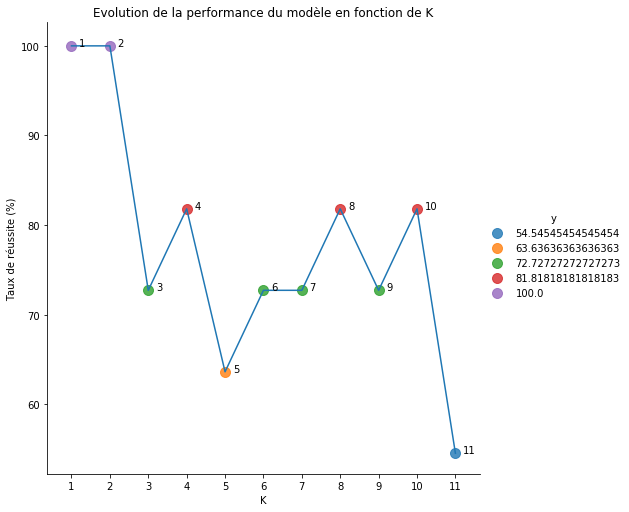

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Affichage graphique du taux de réussite du modèle sur les données fournies en fonction des valeurs de K comprises entre Kmin et Kmax
# INPUT : 
    ## model --> Une fonction représentant notre modèle, elle doit prédire une classe.
    ## dataTrain --> Nos données d'apprentissage
    ## dataTest --> Nos données de test
    ## listAttributs --> La liste des colonnes de notre dataFrame
    ## Kmin --> La valeur de K minimale à afficher 
    ## Kmax --> La valeur de K maximale à afficher
# OUTPUT : 
    ## Affiche la représentation graphique de l'évolution du taux de réussite en foncion de K
def showKnnPerf(model, dataTrain, dataTest, listAttributs, Kmin, Kmax) :
    # Initialisation des données
    x = [i for i in range(Kmin, Kmax+1)] # On met les valeurs de K sur l'axe X
    y = [evalPerf(model, dataTrain, dataTest, i, listAttributs)*100 for i in x] # On met le taux de réussite sur l'axe Y
    data = pd.DataFrame(data={'x': x, 'y': y})

    # Affichage des markers et de la légende
    plot = sns.lmplot('x', 'y', data, height=7, truncate=True, scatter_kws={"s": 100}, ci=None, fit_reg=False, hue='y')
    
    # Affichage de la valeur de K sur les markers
    for i, point in data.iterrows():
            plt.gca().text(point['x']+.2, point['y'], int(point['x']))
    
    plot.set_axis_labels('x')

    # Paramétrages des axes
    plt.plot(x, y) # Affichage de la courbe
    plt.xlabel("K")
    plt.ylabel("Taux de réussite (%)")
    plt.title("Evolution de la performance du modèle en fonction de K")
    plt.xticks(x)
    
    # Affichage
    plt.show()
    
# Test sur les données de l'exercice    
showKnnPerf(predict, normalised_df, normalised_df, attributs, 1, len(normalised_df))

### KNN Avec les données Iris
Pour cette expérience, on va prendre 2/3 des données en apprentissage et 1/3 des données pour les tests. Le graphique prend un peu de temps à s'afficher (environ 20 secondes pour moi).

Taux de réussite du modèle avec K = 10 :  0.94



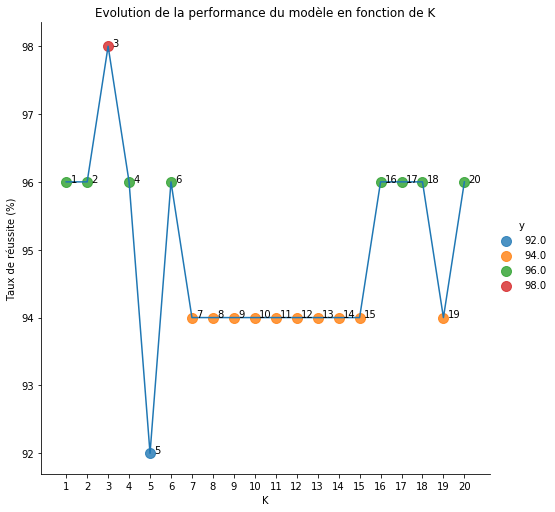

In [12]:
from sklearn import datasets
import sklearn.utils

# Chargement des données Iris
iris = datasets.load_iris()

# Traitement des données des individus
iris_data = pd.DataFrame(iris.data)
iris_data.columns=['Sepal_Length','Sepal_width','Petal_Length','Petal_width']

# Récupération des classes des individus 
iris_class=pd.DataFrame(iris.target)
iris_class.columns=['Class']

# Préparation des données pour qu'elles soient exploitables pour nos fonctions
data = iris_data.join(iris_class)

# Mélange des données car elles sont classées par classe pour le moment
data = sklearn.utils.shuffle(data)

# Initialisation des données nécessaires
attributs_iris = data.columns # Liste des attributs
minAtt = pd.Series(index=attributs_iris[:-1]) # Stockage des valeurs minimales de chaque attributs
maxAtt = pd.Series(index=attributs_iris[:-1]) # Stockage des valeurs maximales de chaque attributs

# Données iris normalisées
normalised_iris = normaliseMinMaxData(data, minAtt, maxAtt) 

# Nos données d'apprentissage : 2/3 des données, soit les 100 premiers individus
dTrain = normalised_iris[:100]

# Nos données de test : 1/3 des données, soit les 50 derniers individus
dTest = normalised_iris[100:]

# Exemple du taux de réussite avec K=10
print("Taux de réussite du modèle avec K = 10 : ", evalPerf(predict, dTrain, dTest, 10, attributs_iris))
print()

# Affichage graphique de la performance de notre modème pour K allant de 1 à 20
showKnnPerf(predict, dTrain, dTest, attributs_iris, 1, 20)